# Imports

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, Dataset
import random 
from torchvision.io import read_image
import time

In [2]:
os.listdir("G:/GeogeussrData/compressed_dataset")

['Aland',
 'Albania',
 'American Samoa',
 'Andorra',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Curacao',
 'Czechia',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Estonia',
 'Eswatini',
 'Faroe Islands',
 'Finland',
 'France',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guam',
 'Guatemala',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iraq',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kenya',
 'Kyrgyzstan',
 'Laos',
 'Latvia',
 'Lebanon',
 'Lesotho',
 'Lithuania',
 'Luxembourg',
 'Macao',
 'Madagascar',
 'Malaysia',
 'Malta',
 'Martinique',
 'Mexico',
 'Monaco',
 'Mongolia',
 'Montenegro',
 'Mozambique',
 'Myanmar',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'North Ma

In [3]:
class_names = ['Aland',
 'Albania',
 'American Samoa',
 'Andorra',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Curacao',
 'Czechia',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Estonia',
 'Eswatini',
 'Faroe Islands',
 'Finland',
 'France',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guam',
 'Guatemala',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iraq',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kenya',
 'Kyrgyzstan',
 'Laos',
 'Latvia',
 'Lebanon',
 'Lesotho',
 'Lithuania',
 'Luxembourg',
 'Macao',
 'Madagascar',
 'Malaysia',
 'Malta',
 'Martinique',
 'Mexico',
 'Monaco',
 'Mongolia',
 'Montenegro',
 'Mozambique',
 'Myanmar',
 'Nepal',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'North Macedonia',
 'Northern Mariana Islands',
 'Norway',
 'Pakistan',
 'Palestine',
 'Paraguay',
 'Peru',
 'Philippines',
 'Pitcairn Islands',
 'Poland',
 'Portugal',
 'Puerto Rico',
 'Qatar',
 'Reunion',
 'Romania',
 'Russia',
 'San Marino',
 'Senegal',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Georgia and South Sandwich Islands',
 'South Korea',
 'South Sudan',
 'Spain',
 'Sri Lanka',
 'Svalbard and Jan Mayen',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Tanzania',
 'Thailand',
 'Tunisia',
 'Turkey',
 'Uganda',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay',
 'US Virgin Islands',
 'Venezuela',
 'Vietnam']

# Data prep

In [36]:
dataset_path = "G:/GeogeussrData/compressed_dataset"

In [37]:
training_transform = t.Compose([t.Resize((150,150)), t.ToTensor()])

In [38]:
data = torchvision.datasets.ImageFolder(root = dataset_path, transform = training_transform)

In [39]:
data_loader = torch.utils.data.DataLoader(dataset = data, batch_size = 32, shuffle = False)

In [40]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        #print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [ ]:

get_mean_and_std(data_loader)

In [41]:
mean = [0.5036, 0.5132, 0.4876]
std = [0.1898, 0.1895, 0.2331]

transform = t.Compose([
    t.Resize((224, 224)), 
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

train_transform = t.Compose([
    t.Resize((224, 224)),
    t.RandomHorizontalFlip(),
    t.RandomRotation(degrees=10),
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

In [42]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path,transform = transform)

In [44]:
from collections import Counter

labels = dataset.targets
label_counts = Counter(labels)

rare_class_indices = [i for i, label in enumerate(labels) if label_counts[label] < 2]
non_rare_indices = [i for i in range(len(labels)) if i not in rare_class_indices]

In [46]:
train_indices, test_indices = train_test_split(
    non_rare_indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=[labels[i] for i in non_rare_indices]
)

train_indices.extend(rare_class_indices)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
len(train_dataset)

40000

In [47]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# CUDA

In [13]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda"
    else:
        dev = "cpu"
    return torch.device(dev)

# Hyperparameter tuning

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


def train_nn_hypertuning(model, train_dataset, criterion, epoch_range, random_search_iterations, class_names):
    best_model = None
    best_accuracy = 0
    best_recall = 0
    best_epoch = 0
    best_lr = 0
    best_wd = 0
    device = set_device()
    start_time = time.time()
    model.to(device)

    validation_results = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for iteration in range(random_search_iterations):
        num_epochs = epoch_range[iteration]
        print(f'Iteration {iteration + 1}/{random_search_iterations}, num_epochs: {num_epochs}')

        for lr in [0.001, 0.01, 0.005, 0.0005, 0.00025]:
            for wd in [0.001, 1e-4, 1e-5, 0.1]:
                print(f'LR={lr}, WD={wd}')
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

                for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(train_dataset)))):
                    print(f'Fold {fold + 1}')
                    train_subsampler = Subset(train_dataset, train_ids)
                    val_subsampler = Subset(train_dataset, val_ids)
                    train_subsampler.dataset.transform = train_transform
                    val_subsampler.dataset.transform = transform

                    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
                    val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False)

                    for epoch in range(num_epochs):
                        epoch_start_time = time.time()

                        epoch_loss, epoch_acc, precision_train, recall_train, f1_train, all_labels, all_preds = \
                            train_epoch(model, train_loader, optimizer, criterion, device)

                        epoch_end_time = time.time()
                        epoch_elapsed_time = epoch_end_time - epoch_start_time
                        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_elapsed_time:.2f} seconds")
                        print(f'Training Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1 Score: {f1_train:.2f}')

                        cm_train = confusion_matrix(all_labels, all_preds)
                        #plot_confusion_matrix(cm_train, class_names, title='Training Confusion Matrix')
                        #print_confusion_matrix_with_totals(cm_train, class_names)

                        cm, precision, recall, f1, val_time, loss = eval_model_test_set(model, val_loader, device, class_names, criterion)
                        print(f'Validation Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Time: {val_time:.2f} seconds')
                        print(f'val loss: {loss:.4f}')
                        #plot_confusion_matrix(cm, class_names, title='Validation Confusion Matrix')
                        #print_confusion_matrix_with_totals(cm, class_names)
                        fold_precisions.append(precision)
                        fold_recalls.append(recall)
                        fold_f1s.append(f1)

                        if recall > best_recall:
                            best_recall = recall
                            best_epoch = num_epochs
                            best_model = model
                            best_lr = lr
                            best_wd = wd
                            save_checkpoint(model, epoch, optimizer, best_recall, lr, wd)
                        

                mean_recall = np.mean(fold_recalls)
                validation_results.append({'lr': lr, 'wd': wd, 'fold': fold + 1, 'recall': mean_recall})
                

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Best lr: {best_lr}')
    print(f'Best wd: {best_wd}')
    print(f'Best validation recall: {best_recall}%')
    print(f'Total training time: {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.2f} seconds')

    plt.figure(figsize=(12, 6))
    for lr in [0.001, 0.01, 0.005, 0.0005, 0.00025]:
        for wd in [0.001, 1e-4, 1e-5, 0.1]:
            recalls = [result['recall'] for result in validation_results if result['lr'] == lr and result['wd'] == wd]
            plt.plot(range(1, len(recalls) + 1), recalls, marker='o', label=f'LR={lr}, WD={wd}')
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Recall')
    plt.title('Validation Recall for Different LR and WD')
    plt.legend()
    plt.show()
    plt.savefig('tuning.png')

    return best_model, best_lr, best_wd

In [15]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    all_labels = []
    all_preds = []

    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        total += labels.size(0)
        optimizer.zero_grad()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * running_correct / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, precision, recall, f1, all_labels, all_preds


In [16]:
def print_confusion_matrix_with_totals(cm, class_names):
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f'True Positives (TP): {tp.sum()}')
    print(f'False Positives (FP): {fp.sum()}')
    print(f'True Negatives (TN): {tn.sum()}')
    print(f'False Negatives (FN): {fn.sum()}')
    print(f'Total: {cm.sum()}')

    return tn, fp, fn, tp, tp + fp + tn + fn

In [17]:
import matplotlib.pyplot as plt

def plot_training_validation_error(training_errors, validation_errors, name, title):
    plt.figure(figsize=(6, 3))
    plt.plot(training_errors,'b-', label='Training Error')
    plt.plot(validation_errors,'r-', label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(name)
    plt.show()

In [18]:
def plot_training_validation(training_recalls, validation_recalls, name, title):
    plt.figure(figsize=(6, 3))
    plt.plot(training_recalls,'b-', label='Training')
    plt.plot(validation_recalls,'r-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(name)
    plt.show()

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def eval_model_test_set(model, val_loader, device, class_names, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    epoch_start_time = time.time()
    total_loss = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    epoch_end_time = time.time()
    epoch_elapsed_time = epoch_end_time - epoch_start_time
    total_loss = total_loss / len(val_loader)

    return cm, precision, recall, f1, epoch_elapsed_time, total_loss

In [21]:
def save_checkpoint( model, epoch, optimizer, best_recall, lr, wd):
    state = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'lr': lr,
        'wd': wd,
        'best_recall': best_recall,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

# Model

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models

class GeoAI(nn.Module):
    def __init__(self, num_classes=124):
        super(GeoAI, self).__init__()
        self.resnet34 = models.resnet34(weights='IMAGENET1K_V1')
        
        num_ftrs = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Identity()  
        
        self.custom_layers = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.resnet34(x)
        x = self.custom_layers(x)
        return x

# hyperparameter tuning start 4 fold

In [26]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights


num_of_classes = 124
model = GeoAI(num_of_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

In [27]:
k_folds = 4
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epoch_range =  [1]

random_search_iterations = 1

Iteration 1/1, num_epochs: 1
LR=0.001, WD=0.001
Fold 1


G:\anaconda\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 2.9268, Accuracy: 33.08%, Time: 1458.79 seconds
Training Precision: 0.34, Recall: 0.33, F1 Score: 0.24
Validation Precision: 0.61, Recall: 0.45, F1 Score: 0.35, Time: 335.20 seconds
val loss: 2.2847
Fold 2


G:\anaconda\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 2.2223, Accuracy: 45.86%, Time: 1420.07 seconds
Training Precision: 0.47, Recall: 0.46, F1 Score: 0.38
Validation Precision: 0.62, Recall: 0.53, F1 Score: 0.47, Time: 305.58 seconds
val loss: 1.8582
Fold 3
Epoch 1, Loss: 1.9097, Accuracy: 51.81%, Time: 1334.83 seconds
Training Precision: 0.52, Recall: 0.52, F1 Score: 0.45
Validation Precision: 0.62, Recall: 0.56, F1 Score: 0.49, Time: 281.93 seconds
val loss: 1.6864
Fold 4
Epoch 1, Loss: 1.7013, Accuracy: 56.07%, Time: 1334.55 seconds
Training Precision: 0.56, Recall: 0.56, F1 Score: 0.51
Validation Precision: 0.64, Recall: 0.60, F1 Score: 0.54, Time: 285.78 seconds
val loss: 1.5037
LR=0.001, WD=0.0001
Fold 1
Epoch 1, Loss: 1.5509, Accuracy: 59.22%, Time: 1326.05 seconds
Training Precision: 0.57, Recall: 0.59, F1 Score: 0.54
Validation Precision: 0.70, Recall: 0.66, F1 Score: 0.61, Time: 270.72 seconds
val loss: 1.2676
Fold 2
Epoch 1, Loss: 1.3993, Accuracy: 62.69%, Time: 1323.69 seconds
Training Precision: 0.62, Recall:

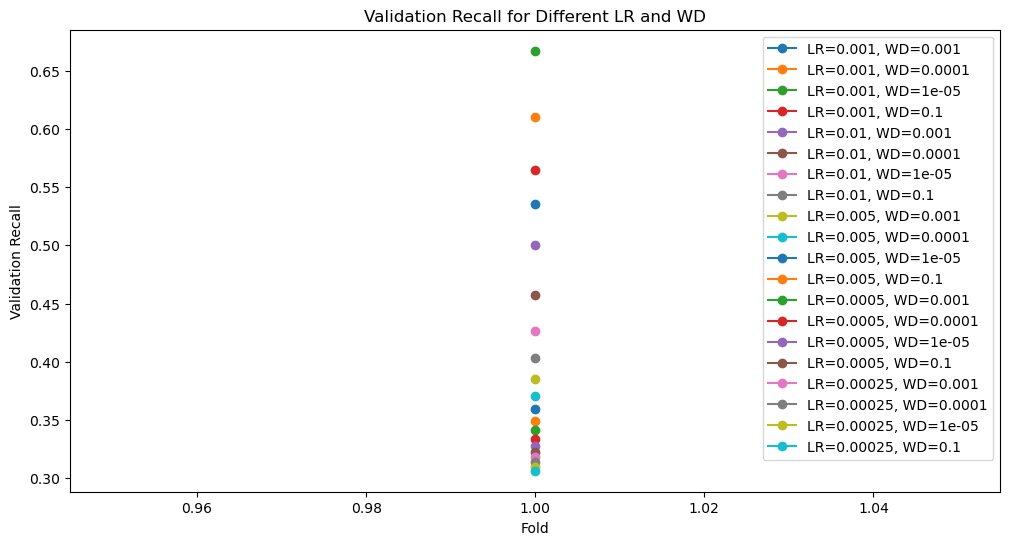

<Figure size 640x480 with 0 Axes>

In [25]:
model, lr, wd = train_nn_hypertuning(model, train_dataset, loss_fn, epoch_range, random_search_iterations, class_names)

# Training

In [28]:
def train_nn(model, train_loader, criterion, optimizer, n_epochs, patience, class_names):
    device = set_device()
    best_recall = 0
    best_epoch = 0
    patience_count = 0
    model.to(device)
    train_recall = []
    train_error = []
    train_precision = []
    train_error_precision = []
    
    start_time = time.time()
    for epoch in range(n_epochs):
        epoch_start_time = time.time()

        # Train for one epoch
        epoch_loss, epoch_acc, precision_train, recall_train, f1_train, all_labels, all_preds = \
                    train_epoch(model, train_loader, optimizer, criterion, device)

        epoch_end_time = time.time()
        epoch_elapsed_time = epoch_end_time - epoch_start_time
        print("[===============================================================================================================================================================]")
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_elapsed_time // 60:.0f} minutes {epoch_elapsed_time % 60:.2f} seconds")
        print(f'Training Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1 Score: {f1_train:.2f}')
        train_recall.append(recall_train)
        train_error.append(1-recall_train)
        train_precision.append(precision_train)
        train_error_precision.append(1-precision_train)

        # Compute confusion matrix for training
        cm_train = confusion_matrix(all_labels, all_preds)
        # Uncomment these lines if you want to visualize or print the confusion matrix
        # plot_confusion_matrix(cm_train, class_names, title='Training Confusion Matrix')
        # print_confusion_matrix_with_totals(cm_train, class_names)

        # Save the best model based on recall
        if recall_train > best_recall:
            best_recall = recall_train
            best_epoch = epoch + 1
            best_model = model
            patience_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_count += 1
            if patience_count >= patience:
                print(f'Recall did not improve for {patience} epochs. Early stopping...')
                break
    
    print("[===============================================================================================================================================================]")

    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Total training time: {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.2f} seconds')
    print(f'Best Training Recall: {best_recall} at Epoch {best_epoch}')

        
    return best_model

In [29]:
num_of_classes = 124
model = GeoAI(num_of_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

In [30]:

lr = 0.001
wd = 1e-05
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
best_model = train_nn(model, train_loader, loss_fn, optimizer, 20, 5, class_names)
torch.save(best_model, 'best_model.pth')

lr: 0.001, wd: 1e-05


G:\anaconda\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[===============================================================================================================================================================]
Epoch 1, Loss: 2.7659, Accuracy: 35.52%, Time: 25 minutes 10.27 seconds
Training Precision: 0.32, Recall: 0.36, F1 Score: 0.27
[===============================================================================================================================================================]
Epoch 2, Loss: 2.0473, Accuracy: 48.71%, Time: 21 minutes 16.11 seconds
Training Precision: 0.48, Recall: 0.49, F1 Score: 0.42
[===============================================================================================================================================================]
Epoch 3, Loss: 1.7267, Accuracy: 55.25%, Time: 20 minutes 47.46 seconds
Training Precision: 0.53, Recall: 0.55, F1 Score: 0.50
[====================================================================================================================================

In [33]:
model = torch.load('best_model.pth')
model.eval()

GeoAI(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [48]:
cm, precision, recall, f1, val_time, loss = eval_model_test_set(model, test_loader, device, class_names, loss_fn)
print(f'Test Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Time: {val_time // 60:.0f} minutes {val_time % 60:.2f} seconds')

Test Precision: 0.90, Recall: 0.90, F1 Score: 0.90, Time: 5 minutes 12.14 seconds


# Classify function

In [65]:
import PIL.Image as Image
from IPython.display import display
import torch

def classify(model, image_transforms, image_path, classes):
    model.eval()  # Set model to evaluation mode
    
    try:
        # Load and transform the image
        image = Image.open(image_path).convert('RGB')
        display(image)  # Optionally display the image
        
        image = image_transforms(image).float()
        image = image.unsqueeze(0)  # Add batch dimension
        device = next(model.parameters()).device
        image = image.to(device)
        
        with torch.no_grad():
            # Get model predictions
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            predicted_index = predicted.item()
            
            # Check for valid class index
            if 0 <= predicted_index < len(classes):
                predicted_class = classes[predicted_index]
                print(f"Predicted Class: {predicted_class}")
            else:
                print(f"Invalid prediction index: {predicted_index}")
    except Exception as e:
        print(f"Error processing the image: {e}")

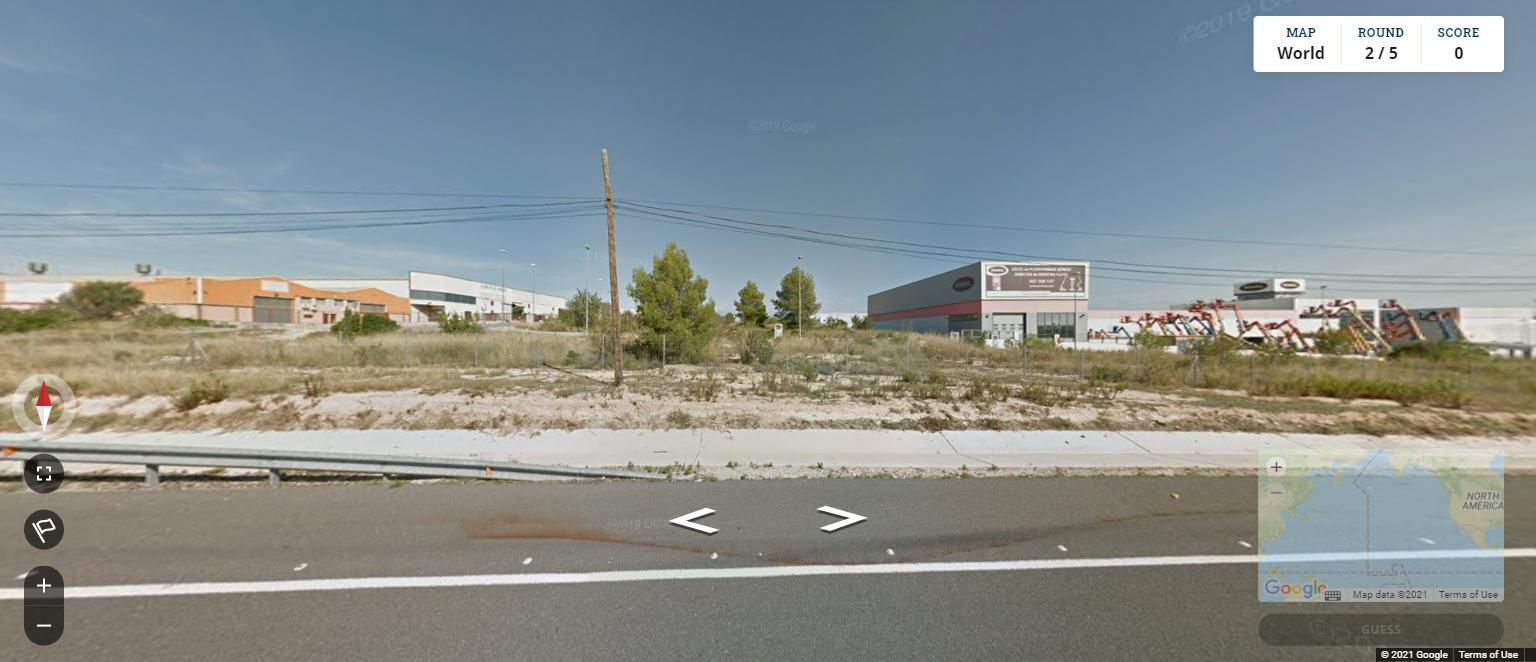

Predicted Class: Spain


In [66]:
model = torch.load('best_model.pth')
classify(model, transform, "test.jpg", class_names)